<a href="https://colab.research.google.com/github/Chiebukar/weapon_detection_Retinanet/blob/main/weapon_detection_retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os

In [ ]:
# installing retinanet
!git clone https://github.com/fizyr/keras-retinanet
os.chdir('keras-retinanet')
!python setup.py install

In [ ]:
# download and copy the Resnet50_Coco file the logos directory
!wget https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5
!mv resnet50_coco_best_v2.1.0.h5 /content/drive/MyDrive/Retinanet/Retinanet_logo_detection/logos

In [4]:
# import required libraries
import keras
import cv2
import keras_retinanet
from google.colab.patches import cv2_imshow

In [ ]:
# # checking retinanent-train command
# !retinanet-train

In [5]:
# redirect worrking dir to base folder
os.chdir('/content/drive/MyDrive/Retinanet/Retinanet_weapon_detection')

In [ ]:
# indicate bash command
%%bash 
mkdir -p config   # create config folder
mkdir weapons/snapshots
mkdir -p image_output
touch config/__init__.py # create __init__.py  file
touch config/logos_config.py # create logos_config.py  file
touch build_weapons.py
touch predict.py

In [ ]:
%%writefile config/weapons_config.py

# import the necessary packages
import os

# initialize the base path for the logos dataset
BASE_PATH = "weapons"

# build the path to the annotations and input images
ANNOT_PATH = os.path.sep.join([BASE_PATH, "annotations"])
IMAGES_PATH = os.path.sep.join([BASE_PATH, "images"])

# define the training/testing split percentage
TRAIN_SPLIT = 0.75

# build the path to the output training and test .csv files
TRAIN_CSV = os.path.sep.join([BASE_PATH, "retinanet_train.csv"])
TEST_CSV = os.path.sep.join([BASE_PATH, "retinanet_test.csv"])

# build the path to the output classes CSV file
CLASSES_CSV = os.path.sep.join([BASE_PATH, "retinanet_classes.csv"])

Writing config/weapons_config.py


In [ ]:
%%writefile build_weapons.py

# USAGE
# python build_weapons.py

# import the necessary packages
from config import weapons_config as config
from bs4 import BeautifulSoup
from imutils import paths
import random
import os

# initialize the set of classes we have encountered so far
CLASSES = set()

# grab all image paths then construct a training and testing split
# from them
imagePaths = list(paths.list_files(config.IMAGES_PATH))
random.shuffle(imagePaths)
i = int(len(imagePaths) * config.TRAIN_SPLIT)
trainImagePaths = imagePaths[:i]
testImagePaths = imagePaths[i:]

# create the list of datasets to build
datasets = [
	("train", trainImagePaths, config.TRAIN_CSV),
	("test", testImagePaths, config.TEST_CSV),
]

# loop over the datasets
for (dType, imagePaths, outputCSV) in datasets:
	# load the contents of the input data split
	print("[INFO] creating '{}' set...".format(dType))
	print("[INFO] {} total images in '{}' set".format(
		len(imagePaths), dType))

	# open the output CSV file
	csv = open(outputCSV, "w")

	# loop over the image paths
	for imagePath in imagePaths:
		# build the corresponding annotation path
		fname = imagePath.split(os.path.sep)[-1]
		fname = "{}.xml".format(fname[:fname.rfind(".")])
		annotPath = os.path.sep.join([config.ANNOT_PATH, fname])

		# load the contents of the annotations file and build the soup
		contents = open(annotPath).read()
		soup = BeautifulSoup(contents, "html.parser")

		# extract the image dimensions
		w = int(soup.find("width").string)
		h = int(soup.find("height").string)

		# loop over all object elements
		for o in soup.find_all("object"):
			# extract the label and bounding box coordinates
			label = o.find("name").string
			xMin = int(o.find("xmin").string)
			yMin = int(o.find("ymin").string)
			xMax = int(o.find("xmax").string)
			yMax = int(o.find("ymax").string)

			# truncate any bounding box coordinates that may fall outside
			# the boundaries of the image
			xMin = max(0, xMin)
			yMin = max(0, yMin)
			xMax = min(w, xMax)
			yMax = min(h, yMax)

			# due to errors in annotation, it may be possible that
			# the minimum values are larger than the maximum values;
			# in this case, treat it as an error during annotation
			# and ignore the bounding box
			if xMin >= xMax or yMin >= yMax:
				continue

			# similarly, we could run into the opposite case where
			# the max values are smaller than the minimum values
			elif xMax <= xMin or yMax <= yMin:
				continue

			# write the image path, bounding box coordinates, and label
			# to the output CSV file
			row = [os.path.abspath(imagePath), str(xMin), str(yMin),
				str(xMax), str(yMax), label]
			csv.write("{}\n".format(",".join(row)))

			# update the set of unqiue class labels
			CLASSES.add(label)

	# close the CSV file
	csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(config.CLASSES_CSV, "w")
rows = [",".join([c, str(i)]) for (i, c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

Overwriting build_weapons.py


In [ ]:
# run build_weapons.py
!python build_weapons.py

[INFO] creating 'train' set...
[INFO] 2250 total images in 'train' set
[INFO] creating 'test' set...
[INFO] 750 total images in 'test' set
[INFO] writing classes...


In [ ]:
# get number of files in train.csv
!wc -l weapons/retinanet_train.csv

2601 weapons/retinanet_train.csv


In [ ]:
# get steps per epochs
2601//2

1300

In [ ]:
# model training
!retinanet-train --batch-size 2 --steps 1125 --epochs 30 \
--weights weapons/resnet50_coco_best_v2.1.0.h5 \
--snapshot-path weapons/snapshots \
csv weapons/retinanet_train.csv weapons/retinanet_classes.csv

Creating model, this may take a second...
2021-11-23 19:58:35.665277: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (No

In [ ]:
# convert model
!retinanet-convert-model weapons/snapshots/resnet50_csv_05.h5 output.h5

In [7]:
# evaluate model
!retinanet-evaluate csv weapons/retinanet_test.csv \
weapons/retinanet_classes.csv output.h5

Loading model, this may take a second...
2021-11-23 23:00:56.345264: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Running network: 100% (750 of 750) |######| Elapsed Time: 1:13:57 Time:  1:13:57
Parsing annotations: 100% (750 of 750) |##| Elapsed Time: 0:00:00 Time:  0:00:00
862 instances of class pistol with average precision: 0.8742
Inference time for 750 images: 5.8818
mAP using the weighted average of precisions among classes: 0.8742
mAP: 0.8742


In [11]:
%%writefile predict.py

# import the necessary packages
from keras_retinanet.utils.image import preprocess_image
from keras_retinanet.utils.image import read_image_bgr
from keras_retinanet.utils.image import resize_image
from keras_retinanet import models
import numpy as np
import argparse
import cv2

# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-m", "--model", required=True,
	help="path to pre-trained model")
ap.add_argument("-l", "--labels", required=True,
	help="path to class labels")
ap.add_argument("-i", "--image", required=True,
	help="path to input image")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
	help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

# load the class label mappings
LABELS = open(args["labels"]).read().strip().split("\n")
LABELS = {int(L.split(",")[1]): L.split(",")[0] for L in LABELS}

# load the model from disk
model = models.load_model(args["model"], backbone_name="resnet50")

# load the input image (in BGR order), clone it, and preprocess it
image = read_image_bgr(args["image"])
output = image.copy()
image = preprocess_image(image)
(image, scale) = resize_image(image)
image = np.expand_dims(image, axis=0)

# detect objects in the input image and correct for the image scale
(boxes, scores, labels) = model.predict_on_batch(image)
boxes /= scale

# loop over the detections
for (box, score, label) in zip(boxes[0], scores[0], labels[0]):
	# filter out weak detections
	if score < args["confidence"]:
		continue

	# convert the bounding box coordinates from floats to integers
	box = box.astype("int")

	# build the label and draw the label + bounding box on the output
	# image
	label = "{}: {:.2f}".format(LABELS[label], score)
	cv2.rectangle(output, (box[0], box[1]), (box[2], box[3]),
		(0, 255, 0), 2)
	cv2.putText(output, label, (box[0], box[1] - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# save the output image
cv2.imwrite('image_output/output.jpg', output)
# # show the output image
# cv2.imshow("Output", output)
# cv2.waitKey(0)

Overwriting predict.py


In [ ]:
# make prediction
!python predict.py --model output.h5 --labels weapons/retinanet_classes.csv \
--image weapons/images/armas_1.jpg --confidence 0.5

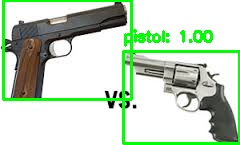

In [14]:
# show predicted image
image = cv2.imread('image_output/output.jpg')
cv2_imshow(image)